# **Lab 5: Wide and Deep Networks**
**Name(s):** Luke Voinov, Tiffany Nguyen, Emmanuel Garcia, Nimai Keshu

We use the Book Recommendation dataset:

https://www.kaggle.com/datasets/oscarm524/book-recommendation?select=items.csv

This dataset will take as input details about transactions for a specific book. Given the details about how a specific user interacts with a book, and given a model that has learned the relationship between each book, this system will try to predict how many books a user ordered.

Much of the code in this dataset was adapted from Eric Larson, MachineLearningNotebooks/10a. Keras Wide and Deep as TFData.ipynb:

https://github.com/eclarson/MachineLearningNotebooks/blob/4c21e29effcd7d7b9ba7f06a841d91d23cc11319/10a.%20Keras%20Wide%20and%20Deep%20as%20TFData.ipynb

We will denote this reference with (1)


In [2]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Pre-processing**

### **1.1 Preparation**

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used (include a description of any newly formed variables you created). It is preferred to use tf.dataset and Keras Feature spaces for pre-processing, but it is not required.*

First, we have to clean and merge some datasets

In [3]:
# Code adapted from Github Copilot to work with pipe delimiters and other csv issues

#path1 = "items.csv"
#path2 = "transactions.csv"
path1 = "/content/items.csv"
path2 = "/content/transactions.csv"

# read the items.csv (book information) into df1
df1 = pd.read_csv(path1, sep='|', usecols=range(6),
                  names=['itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics'],
                  skiprows=1, encoding='utf-8', quoting=3)

# Read the transaction information into df2
df2 = pd.read_csv(path2, sep='|', usecols=range(5),
                  names=['customer', 'itemID', 'click', 'basket', 'order'], # rename sessionID to custmer for mor clarity
                  skiprows=1, encoding='utf-8')

# General infomation about df1
print("Items DataFrame:")
print(df1.head())
print(f"\nItems shape: {df1.shape}")
print(f"Items columns: {df1.columns.tolist()}")
print(f"Items dtypes:\n{df1.dtypes}")

Items DataFrame:
   itemID                                      title              author  \
0   21310             Princess Poppy: The Big Mix Up  Janey Louise Jones   
1   73018             Einfach zeichnen! Step by Step       Wiebke Krabbe   
2   19194                                Red Queen 1    Victoria Aveyard   
3   40250         Meine Kindergarten-Freunde (Pirat)                 NaN   
4   46107  Mein großes Schablonen-Buch - Wilde Tiere   Elizabeth Golding   

                            publisher main_topic  \
0  Penguin Random House Children's UK        YFB   
1              Schwager und Steinlein        AGZ   
2              Orion Publishing Group        YFH   
3                    Ars Edition GmbH         YB   
4             Edition Michael Fischer       WFTM   

                       subtopics  
0                          [5AH]  
1  [5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]  
2                      [5AP,FBA]  
3           [5AC,5AD,YBG,YBL,YF]  
4   [WD,WFTM,YBG,YBL,YBLD,YBLN1]  

It

In [4]:
# General information about df2

print("Transactions DataFrame:")
print(df2.head())
print(f"\nTransactions shape: {df2.shape}")
print(f"Transactions columns: {df2.columns.tolist()}")

Transactions DataFrame:
   customer  itemID  click  basket  order
0         0   21310      1       0      0
1         1   73018      1       0      0
2         2   19194      1       0      0
3         3   40250      1       0      0
4         4   46107      1       0      0

Transactions shape: (365143, 5)
Transactions columns: ['customer', 'itemID', 'click', 'basket', 'order']


In [5]:
# Code from Github Copilot was adapted to merge and clean the dataset
# Merge the two DataFrames on 'itemID'

# Clean itemID: remove any quotes and convert to int in both DataFrames
df1['itemID'] = df1['itemID'].astype(str).str.replace('"', '', regex=False).str.strip().astype(int)
df2['itemID'] = df2['itemID'].astype(str).str.replace('"', '', regex=False).str.strip().astype(int)

df = pd.merge(df2, df1, on='itemID', how='inner') # each transaction associated with a book id was matched with the book id and its information

print(f"Merged DataFrame shape: {df.shape}")
print(f"Merged columns: {df.columns.tolist()}")
df.head(10)

Merged DataFrame shape: (365143, 10)
Merged columns: ['customer', 'itemID', 'click', 'basket', 'order', 'title', 'author', 'publisher', 'main_topic', 'subtopics']


,customer,itemID,click,basket,order,title,author,publisher,main_topic,subtopics
0,0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,1,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,2,19194,1,0,0,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,3,40250,1,0,0,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,4,46107,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"
5,5,34217,1,0,0,Ewig geliebt,J. R. Ward,Heyne Taschenbuch,FMR,"[1KBB-US-NAK,FMX,FRX,3MRBF]"
6,6,31436,1,0,0,Meine Sticker-Tiere,NaN,Ars Edition GmbH,YBG,"[5AD,YBG,YBLL]"
7,7,14576,1,1,0,Unsterblich 01 - Tor der Dämmerung,Julie Kagawa,Heyne Taschenbuch,YFE,"[5AQ,FM,YFE,YFH]"
8,7,17731,2,1,0,Unsterblich 02 - Tor der Nacht,Julie Kagawa,Heyne Taschenbuch,YFH,"[5AQ,FM,YFE,YFH]"
9,8,58723,1,0,0,Pedro und die Bettler von Cartagena,Ursula Hasler,dtv Verlagsgesellschaft,YFB,"[5AM,1KLSC]"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365143 entries, 0 to 365142
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   customer    365143 non-null  int64 
 1   itemID      365143 non-null  int64 
 2   click       365143 non-null  int64 
 3   basket      365143 non-null  int64 
 4   order       365143 non-null  int64 
 5   title       365143 non-null  object
 6   author      323809 non-null  object
 7   publisher   365142 non-null  object
 8   main_topic  364248 non-null  object
 9   subtopics   365143 non-null  object
dtypes: int64(5), object(5)
memory usage: 27.9+ MB


*1.2 Remove any observations that having missing data.*

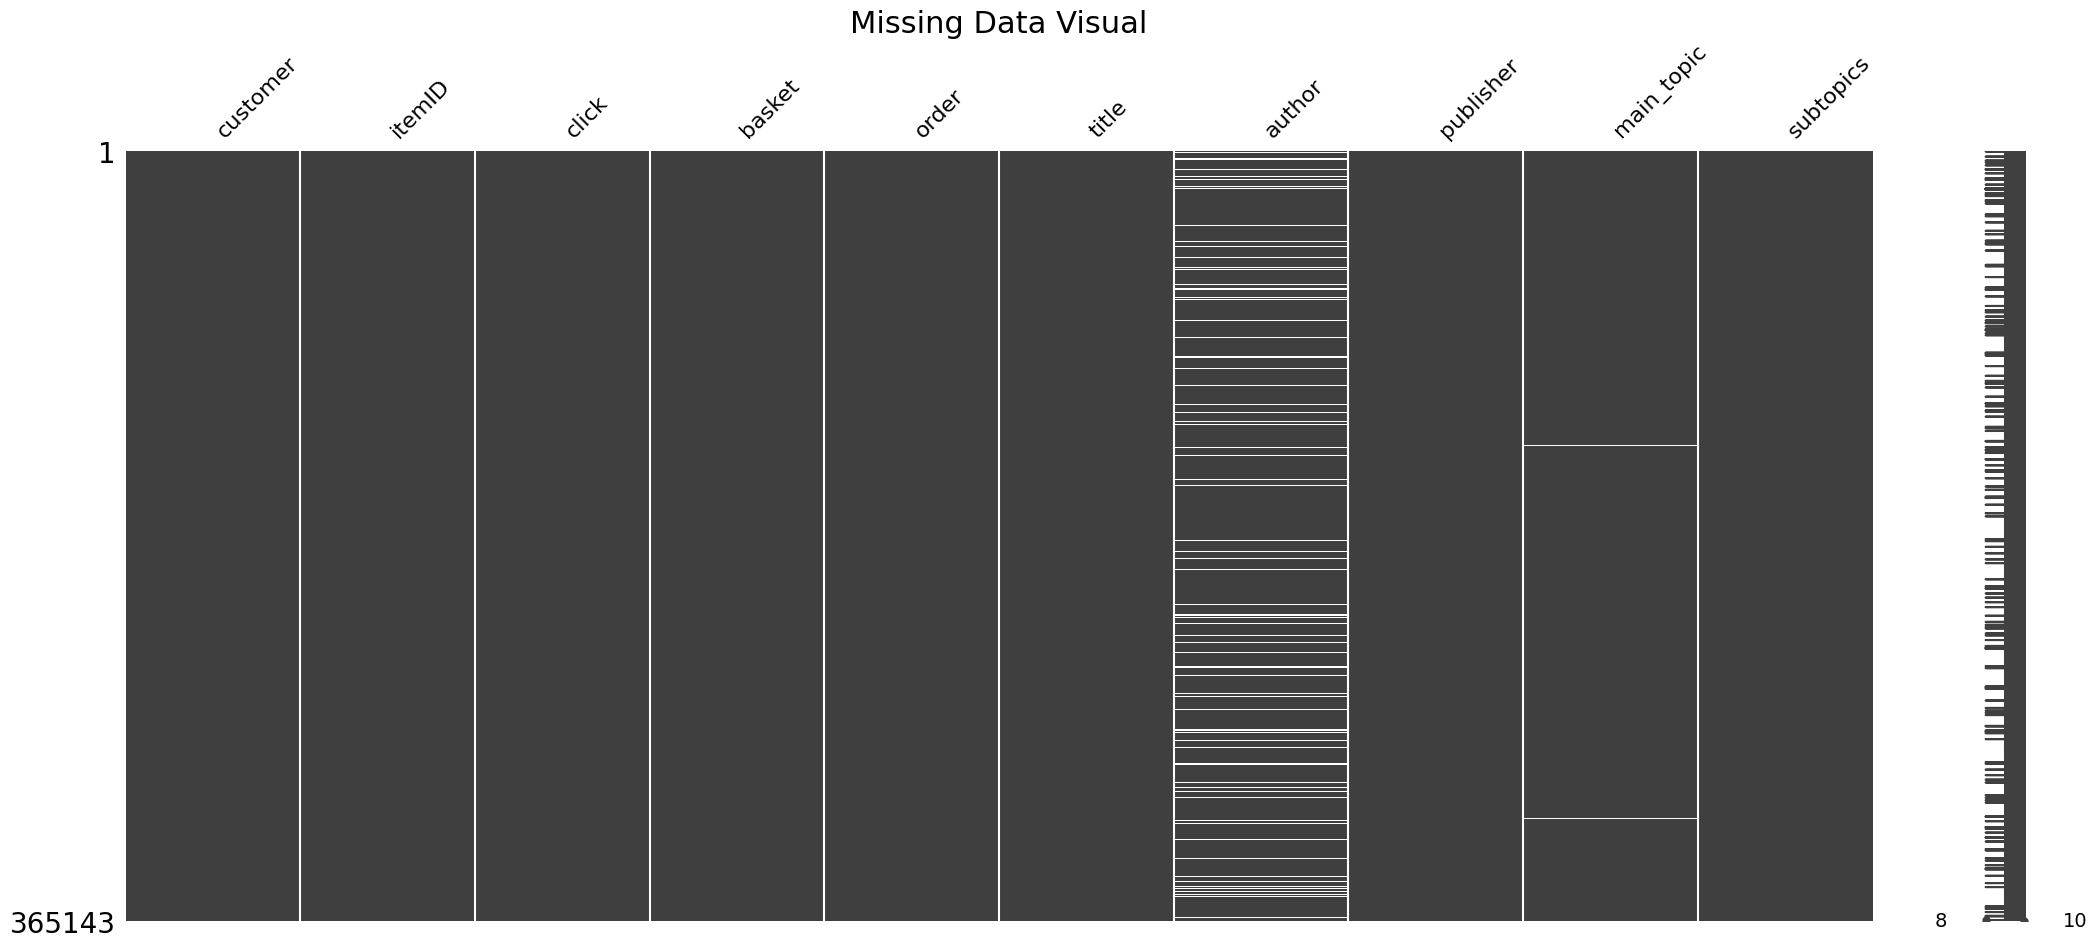

In [7]:
"""
Code used from voinov_lab4
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# External package: conda install missingno
import missingno as mn

mn.matrix(df)
plt.title("Missing Data Visual",fontsize=22)
plt.show()

In [8]:
print(df.isnull().sum())  # Shows the count of missing values per column

customer          0
itemID            0
click             0
basket            0
order             0
title             0
author        41334
publisher         1
main_topic      895
subtopics         0
dtype: int64


We can see that no column is missing too much data (365k books vs 41k missing authors). Therefore, it is okay to leave these missing values as they are; imputation is not necessary.

In [9]:
"""
Code adapted from voinov_lab4

Delete any rows that contain missing data
"""

# also delete any row that has any missing value
df_clean = df.dropna().reset_index(drop=True)

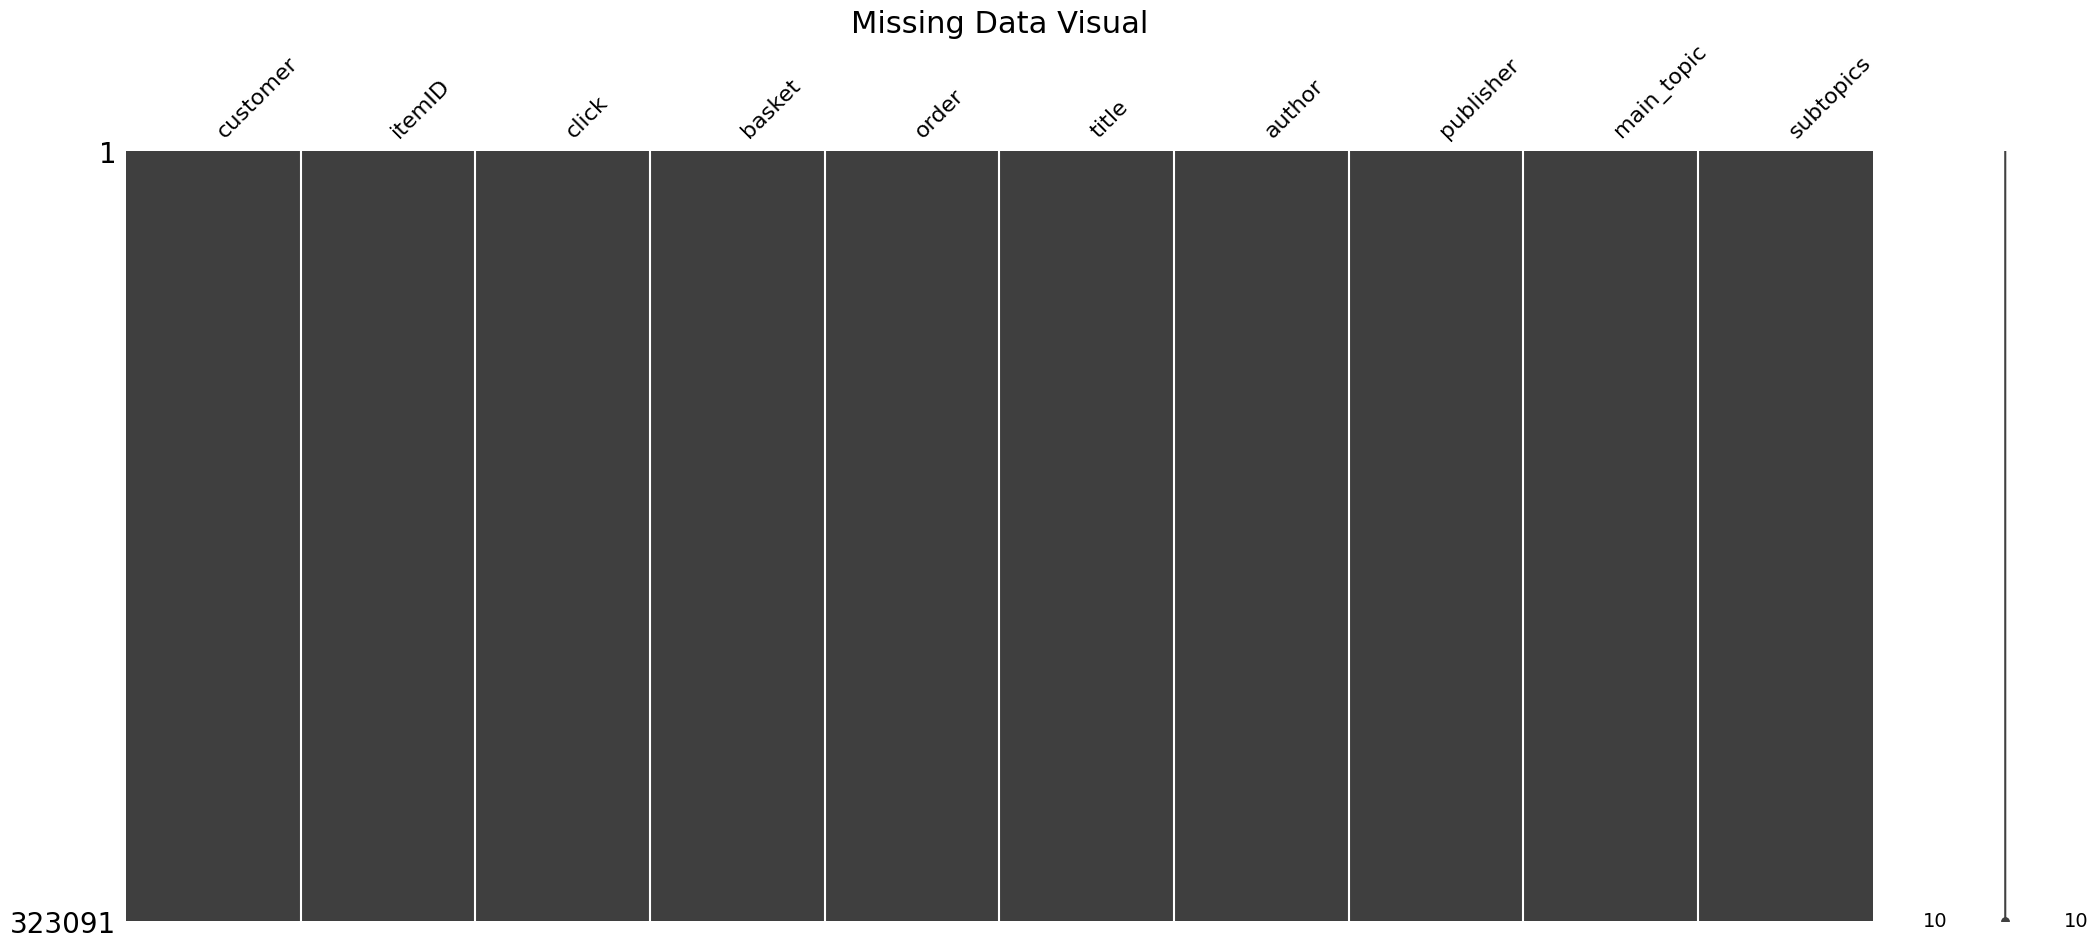

,0
customer,323091
itemID,323091
click,323091
basket,323091
order,323091


In [10]:
"""
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# External package: conda install missingno
import missingno as mn

mn.matrix(df_clean)
plt.title("Missing Data Visual",fontsize=22)
plt.show()

df_clean.count().head()

We started with 365143 and ended with 284935 books. This means that deleting every row with a missing value deleted ~20% of the data. This is large but because we have so many data points it's permitable

In [ ]:
# export df to csv for simpler loading
df_clean.to_csv("clean_books")

In [3]:
# For Tiffany, Emmanuel, and Nimai to load cleaned data directly w/ provided cleaned_books.csv file from previous sections
# Run this line then the rest beneath

df_clean = pd.read_csv("clean_books", index_col=0)

Now, we encode and scale


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323091 entries, 0 to 323090
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   customer    323091 non-null  int64 
 1   itemID      323091 non-null  int64 
 2   click       323091 non-null  int64 
 3   basket      323091 non-null  int64 
 4   order       323091 non-null  int64 
 5   title       323091 non-null  object
 6   author      323091 non-null  object
 7   publisher   323091 non-null  object
 8   main_topic  323091 non-null  object
 9   subtopics   323091 non-null  object
dtypes: int64(5), object(5)
memory usage: 24.7+ MB


We will use order as our target variable because we want to suggest the top three books that they're most likely to order.

Notice that most variables are categorical It might seem like click and basket could also be categorical because the df.head makes it look like they are binary, but these are numeric count features representing the number of times a customer clicked on or added a book to their basket. Click ranges from 0-118 and basket varies from 0-293.

In [13]:
# Code is adapted from (1)
# This code sets apart the target, categorical, and numerical variables.

from sklearn.preprocessing import LabelEncoder

# ========================================================
target = 'order'  # Predict whether a customer will order a book

# ========================================================
# define variables that should be encoded as categorical (and then OHE)
categorical_headers = ['customer', 'itemID', 'title', 'author', 'publisher',
                       'main_topic', 'subtopics']

# define numeric features (count variables that should be normalized)
numeric_headers = ['click', 'basket']

# get unique values in each feature
for col in categorical_headers:
    print(f'{col} has {len(df_clean[col].unique())} unique values.')

for col in numeric_headers:
    print(f'{col} ranges from {df_clean[col].min()} to {df_clean[col].max()}')

# Convert numeric features to float
df_clean[numeric_headers] = df_clean[numeric_headers].astype(float)

# Convert customer and itemID to strings for string_categorical encodingdf_clean.head()

df_clean['customer'] = df_clean['customer'].astype(str)
df_clean['itemID'] = df_clean['itemID'].astype(str)

customer has 242773 unique values.
itemID has 22788 unique values.
title has 21479 unique values.
author has 10675 unique values.
publisher has 2367 unique values.
main_topic has 581 unique values.
subtopics has 7390 unique values.
click ranges from 0 to 118
basket ranges from 0 to 293


We will group the target variable into 4 groups to address class imbalance


In [14]:
from sklearn.utils import resample

def group_orders(order_count):
    if order_count == 0:
        return 0
    elif order_count == 1:
        return 1
    elif order_count == 2:
        return 2
    else:
        return 3  # 3+ orders grouped together

df_clean['order_grouped'] = df_clean['order'].apply(group_orders)

order_dist = df_clean['order_grouped'].value_counts().sort_index()
print("\nGrouped Order Distribution:")
for group, count in order_dist.items():
    print(f"Orders ({group}): {count}")

# Conversion rates for grouped orders
total_customers = len(df_clean)
print("\nGrouped Order Percentages:")
for group in range(4):
    count = order_dist.get(group, 0)
    conversion_rate = (count / total_customers) * 100
    print(f"Percentages of order group ({group}): {conversion_rate:.2f}%")

# Adapted from Copilot to stratify based on grouped order counts
print("Grouped order distribution:")
print(df_clean['order_grouped'].value_counts())


# Undersampling code below adapted from Claude AI
df_class_0 = df_clean[df_clean['order_grouped'] == 0]
df_class_1 = df_clean[df_clean['order_grouped'] == 1]
df_class_2 = df_clean[df_clean['order_grouped'] == 2]
df_class_3 = df_clean[df_clean['order_grouped'] == 3]
df_class_0_downsampled = resample(
    df_class_0,
    n_samples=30000,
    random_state=42,
    replace=False
)
df_clean = pd.concat([
    df_class_0_downsampled,
    df_class_1,
    df_class_2,
    df_class_3
])

df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nNew balanced distribution:")
print(df_clean['order_grouped'].value_counts().sort_index())
print(f"\nNew class percentages:")
for i in range(4):
    pct = (df_clean['order_grouped'] == i).mean() * 100
    print(f"  Class {i}: {pct:.2f}%")
print(f"\nTotal samples: {len(df_clean)} (down from {total_customers})")
print("="*60 + "\n")


Grouped Order Distribution:
Orders (0): 307471
Orders (1): 15367
Orders (2): 203
Orders (3): 50

Grouped Order Percentages:
Percentages of order group (0): 95.17%
Percentages of order group (1): 4.76%
Percentages of order group (2): 0.06%
Percentages of order group (3): 0.02%
Grouped order distribution:
order_grouped
0    307471
1     15367
2       203
3        50
Name: count, dtype: int64

New balanced distribution:
order_grouped
0    30000
1    15367
2      203
3       50
Name: count, dtype: int64

New class percentages:
  Class 0: 65.76%
  Class 1: 33.68%
  Class 2: 0.44%
  Class 3: 0.11%

Total samples: 45620 (down from 323091)



In [15]:
# Code is adapted from (1)
# This code is used to create a dataset in Keras so that it could perform graph operation on all the inputs
batch_size = 64

def create_dataset_from_dataframe(df_input):
    ''' This function will create a tf.dataset using all columns in a df
        The df will have both numeric and categorical headers
    '''
    print('Creating dataset with the following Categorical headers:', categorical_headers)
    print('Creating dataset with the following Numeric headers:', numeric_headers)

    df = df_input.copy()
    labels = df['order_grouped']
    # encoding line below adapted from Claude AI
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)

    # get both categorical and numeric features
    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    # now enable batching and prefetching
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(batch_size)

    return ds

ds = create_dataset_from_dataframe(df_clean)

Creating dataset with the following Categorical headers: ['customer', 'itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics']
Creating dataset with the following Numeric headers: ['click', 'basket']


Now we will create the feature space for each categorical variable and normalize click and basket.

### **1.2 Identifying Cross-Product Features**

Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or, alternatively, why some features should not be crossed)*

Cross product features should be the categorical variables that, when crossed, reveal some 'emergent' relationship. While the two/three variables on their own do provide individual information, the algorithm could learn the new form of information due to their complex relationships could be learned when they're crossed. Thus, the business case for crossing these variables is that it'd allow us to learn relations deeper and thus provide better results.

Two features that might benefit from crossing are author + publisher. It isn't too far fetched to believe that authors have a favorite / established publisher, so the algorithm may learn some more information from those relations.

Some other features could be publisher + main_topic and publisher + subtopics. It's also not unreasonable to assume that certain publishers lean toward publishing certain topics, and this crossing would tease out some of that realtionship.

Another crossing could involve the author + main_topic and author + subtopics. This crossing would inform the model of the rleation between the author and their commonly explored themes, providing a richer way to measure how similar books might be based on the author.

The title + main_topic could be crossed. This crossing would allow the model to see more complex patterns between book themes and the topics the books present, allowing the model to better match books / cluster them in the embedding space.

Finally, and arguably the most important crossings, are customer + author and customer + main_topic and customer + subtopics. The customer will likely have a perference for authors and topics.

Click and basket shouldn't be crossed because they're numeric features, itemID doesn't make sense to cross with anything other than maybe customer because itemID is an abstraction of a book, and title + publisher wouldn't provide as much information as the ones mentioned (publishers hopefully don't judge a book by its cover but consider the author and the themes and the writing significanlty more).

### **1.4 Data Splitting Method**
*Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate and use this method during training. Argue why your splitting method is a realistic mirroring of how an algorithm would be used in practice.*

We use a stratified train-test split rather than cross-validation. Because our dataset is large (280,000+ observations), a single well-balanced split is sufficient to estimate out-of-sample performance reliably. Stratification ensures that the distribution of our target classes is preserved in both the training and testing sets, preventing class imbalance from unintentionally biasing model evaluation. Cross-validation is more appropriate when datasets are small and model performance is highly sensitive to sampling fluctuations. In our case, however, 10-fold cross-validation would require training 10 separate models—significantly increasing computational cost without providing a meaningful improvement in estimation accuracy, given the size and stability of our dataset.

A stratified train–test split also mirrors how the model would be used in practice. In real deployment settings, an organization typically trains one final model on all available historical data and then evaluates it once on a held-out set before deployment. Businesses rarely retrain the same model 10 times on different folds unless hyperparameter tuning requires it. Therefore, our approach reflects a realistic production workflow: train a single model, validate it once on a representative hold-out sample, and deploy.

In [ ]:
# Train, test, split
# Now stratify on grouped version
train_val_df, test_df = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=df_clean['order_grouped']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df['order_grouped']
)

print("\nTrain shape:", train_df.shape) # Should be 64% of data
print("Validation shape:", val_df.shape) # Should be 16% of data
print("Test shape:", test_df.shape) # Should be 20% of data

# 3 lines below adapted from Claude AI.
ds_train = create_dataset_from_dataframe(train_df)
ds_val = create_dataset_from_dataframe(val_df)
ds_test = create_dataset_from_dataframe(test_df)


Train shape: (29196, 11)
Validation shape: (7300, 11)
Test shape: (9124, 11)
Creating dataset with the following Categorical headers: ['customer', 'itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics']
Creating dataset with the following Numeric headers: ['click', 'basket']
Creating dataset with the following Categorical headers: ['customer', 'itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics']
Creating dataset with the following Numeric headers: ['click', 'basket']
Creating dataset with the following Categorical headers: ['customer', 'itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics']
Creating dataset with the following Numeric headers: ['click', 'basket']


It should be prepared to be modeled now that we have split our dataset!

In [ ]:
# Now cross the features
# This code is adapted from (1)
# This code dynamically creates a feature space for each categorical (and numeric) feature. Now we'll be able to measure how close they are to each other.
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "customer":       FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),
        "itemID":         FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),
        "title":          FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),
        "author":         FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),
        "publisher":      FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),
        "main_topic":     FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),
        "subtopics":      FeatureSpace.string_categorical(num_oov_indices=1, output_mode='int'),

        # Numeric count features (normalized)
        "click":          FeatureSpace.float_normalized(),
        "basket":         FeatureSpace.float_normalized(),


    },
    # Specify feature cross with a custom crossing dim
    # dim = number of unique values for each category
    crosses=[
        FeatureSpace.cross(
            feature_names=('author','publisher'), # dims: 6998 x 1434
            crossing_dim=10000, output_mode='int'), # used to be 10000
        # new in TF 2.12, three tuples not allowed...
        FeatureSpace.cross(
            feature_names=('author','customer'), # 6998 x 213289
            crossing_dim=50000, output_mode='int'),
        FeatureSpace.cross(
            feature_names=('main_topic','customer'), # 572 x 213289
            crossing_dim=50000, output_mode='int'),
        FeatureSpace.cross(
            feature_names=('subtopics','customer'), # 7396 x 213289
            crossing_dim=50000, output_mode='int'),
        FeatureSpace.cross(
            feature_names=('title','main_topic'), # 15205 x 572
            crossing_dim=10000, output_mode='int'), # used to be 10000
        FeatureSpace.cross(
            feature_names=('publisher','main_topic'), # 1434 x 572
            crossing_dim=5000, output_mode='int'),
        FeatureSpace.cross(
            feature_names=('publisher','subtopics'), # 1434 x 7396
            crossing_dim=10000, output_mode='int'),
        FeatureSpace.cross(
            feature_names=('author','main_topic'), # 6998 x 572
            crossing_dim=10000, output_mode='int'), # used to be 10000
        FeatureSpace.cross(
            feature_names=('author','subtopics'), # 6998 x 7396
            crossing_dim=10000, output_mode='int'),
    ],
    output_mode="dict",
)

# customer has 213289 unique values.
# itemID has 15963 unique values.
# title has 15205 unique values.
# author has 6998 unique values.
# publisher has 1434 unique values.
# main_topic has 572 unique values.
# subtopics has 7396 unique values.
# click ranges from 0 to 118
# basket ranges from 0 to 293

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

# now define a preprocessing operation that returns the processed features
preprocessed_ds_train = ds_train.map(lambda feat, labels: (feature_space(feat), labels),
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

# Additional preprocess code below adapted from Claude AI.
preprocessed_ds_val = ds_val.map(lambda feat, labels: (feature_space(feat), labels),
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_val = preprocessed_ds_val.prefetch(tf.data.AUTOTUNE)


preprocessed_ds_test = ds_test.map(lambda feat, labels: (feature_space(feat), labels),
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

(this cell was formatted by github copilot)

The final dataset used has the following 9 input features:

- **customer** (categorical, 213,289 unique values)
    - Represents a user browsing the online book store

- **itemID** (categorical, 15,963 unique values)
    - Represents the book (encoded as an ID)

- **title** (categorical, 15,205 unique values)
    - Represents the book title

- **author** (categorical, 6,998 unique values)
    - Represents who wrote the book

- **publisher** (categorical, 1,434 unique values)
    - Represents what group published the book

- **main_topic** (categorical, 572 unique values)
    - Represents what the main topic is (young adult, fantasy, non-fiction, etc.)

- **subtopics** (categorical, 7,396 unique values)
    - Represents the subtopics in the book, same as above but more than just one topic
    
- **click** (numeric float, range: 0-118)
    - Represents how many times the user clicked on the book to see more details about it

- **basket** (numeric float, range: 0-293)
    - Represents how many of the book the customer added to their basket

**Target Variable:**
- **order_grouped** (categorical, 4 classes: 0, 1, 2, 3+)
    - Groups the order counts into 4 categories: no orders (0), one order (1), two orders (2), and three or more orders (3+). This multi-class classification problem tries to predict how many books the customer will order.

**Crossed Features:**
We have 9 crossed features as well, adding up to 18 features in total. The crossed features are described and justified in the crossed features section above.

**Dataset Size and Splitting:**
After removing missing values (resulting in 284,935 records) and  undersampling to address class imbalance, our final dataset contains 44,699 observations. The original dataset was heavily imbalanced with approximately 91% of records having zero orders. We undersampled the majority class (order_grouped=0) to 30,000 records while keeping all minority class samples, resulting in balancing.

The dataset was split using stratified train-test splitting to preserve class distribution across splits:
- **Training set**: 64% of data 
- **Validation set**: 16% of data 
- **Test set**: 20% of data 

Stratification was used because even after undersampling, the dataset remains imbalanced. By stratifying on `order_grouped`, we ensured that each split contains representative proportions of all four order categories, preventing the model from being biased.

### **1.3 Metric(s) to evaluate algorithm's performance**

*Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use, but sometimes it can be. Think critically about an appropriate measure of performance and explain this reasoning.*

Some metrics that we could consider using to evaluate our algorithm's performance are: precision, recall, and F1-Score. However, we want to utilize them for a multi-class classification. However, we should check if our dataset is imbalanced so that way we can consider accuracy as a metric.

**Why Accuracy is not appropriate for our problem**

Because our dataset is heavily imbalanced with the majority of interactions resulting in no order-accuracy becomes a misleading performance metric. A model could achieve a deceptively high accuracy simply by predicting the majority class (“no order”) for almost every case. Such a model would appear to perform well numerically while failing entirely at the actual business objective, which is identifying customers who will order and recommending products they are likely to buy.

In imbalanced classification settings, accuracy essentially rewards doing nothing: it ignores the cost of missing rare but valuable positive cases, and it hides the model’s inability to detect them. Therefore, relying on accuracy would overestimate the effectiveness of our system and would not reflect meaningful predictive performance.

**Now, for our reasons why we chose precision, recall, and F1-Score:**
- **Precision**: This metric can measure the quality of our recommendations, especially in a business case. One question that a business could ask: "Out of the three books we recommend to a customer, how many will they actually purchase?" With precision, it can measure our model's ability to avoid false positives. In this case, it means that a false positive is recommending a book the customer won't order, which wastes an opportunity to show them something they'd actually want based on their interests (authors they've read, topics, etc.) What we want to achieve from this metric is to at least have 1 out of the 3 books ordered. Anything that results in 0 out of 3 is considered a failure.


- **Recall**: This metric can capture the opportunity cost. Low recall in this case would mean that we're missing sales by failing to recommend books customers would have bought. They might leave and find books elsewhere. A question a business could ask: "Of all books a customer would order, how many appear in our top 3 recommendations?" This metric would measure our model's ability to avoid false negatives (not false positives like Precision). False negatives in our case would mean failing to recommend a book the customer would have ordered, which would be a missed revenue opportunity (from a business perspective, we want to make as much money as we can by recommending books to customers).


- **F1-Score**: We cannot forget about F1-Score if we are already considering Precision and Recall as some of ours. By having F1-Score, we can balance precision and recall into a single metric. We cannot use Precision and Recall alone for this dataset, especially with how maximizing precision would only recommend obvious bestsellers, in return hurting the recall metric, but maximizing Recall would mean we'd recommend many books, which would hurt precision in return. The F1-Score can bring balance to an imbalanced dataset such as what we are working with now. By doing so, we are ensuring that we don't sacrifice one metric for the other, hence why we chose F1-Score as one of the metrics.

## **Modeling**

In [56]:
# Creates one function to perform embedding for the deep network, and one for the wide network

def setup_embedding_from_encoding_crossing(encoded_features, feature_space, col_name):
    x = encoded_features[col_name]
    N = feature_space.crossers[col_name].num_bins
    # max_dims variable adapted from Claude AI
    max_dims = min(int(np.sqrt(N)), 128)

    x = Embedding(input_dim=N,
                  output_dim=max_dims,
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x)
    return x

def setup_embedding_from_encoding_categorical(encoded_features, feature_space, col_name):
    x = encoded_features[col_name]
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    max_dims = min(int(np.sqrt(N)), 64)

    x = Embedding(input_dim=N,
                  output_dim=max_dims,
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x)

    return x

# Model 1

In [48]:
# Warning suppression, class weight computation, and l2 regularization generated by Claude AI.
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')


# Creates the first wide and deep network model
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()
crossed_outputs = []

for col in feature_space.crossers.keys():
    x = setup_embedding_from_encoding_crossing(encoded_features, feature_space, col)
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numeric_headers:
    x = encoded_features[col]
    # Casting line below adapted from Claude AI.
    x = keras.ops.cast(x, float)
    all_deep_branch_outputs.append(x)

for col in categorical_headers:
    x = setup_embedding_from_encoding_categorical(encoded_features,feature_space, col)
    all_deep_branch_outputs.append(x)

#kernel_regularizer adapted from Claude AI
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', kernel_regularizer=l2(0.001), name='deep1')(deep_branch)
deep_branch = Dropout(0.7)(deep_branch)
deep_branch = Dense(units=25,activation='relu', kernel_regularizer=l2(0.001), name='deep2')(deep_branch)
deep_branch = Dropout(0.5)(deep_branch)
deep_branch = Dense(units=10,activation='relu', kernel_regularizer=l2(0.001), name='deep3')(deep_branch)
deep_branch = Dropout(0.3)(deep_branch)

final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
#softmax adapted from Claude AI
final_branch = Dense(units=4,activation='softmax',
                     name='combined')(final_branch)

training_model = keras.Model(inputs=encoded_features, outputs=final_branch)
training_model.compile(
    # categorical_crossentropy adapted from Claude AI.
    optimizer="adam", loss='categorical_crossentropy', metrics=['precision', 'recall']
)

training_model.summary()
inference_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
inference_model.compile(loss='categorical_crossentropy', metrics=['precision', 'recall'])


# class weight calculation, early stopping, and learning rate reduction code adapted from Claude AI
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2, 3]),
    y=df_clean['order_grouped']
)
class_weight_dict = {i: class_weights[i] for i in range(4)}
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)


history = training_model.fit(
    preprocessed_ds_train, epochs=5, validation_data=preprocessed_ds_val,
    class_weight=class_weight_dict, callbacks=[early_stop, reduce_lr],
    verbose=2
)

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_646CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_647CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_648CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_649CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_650CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_651CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_652CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_653CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_654CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ customer_embed      │ (None, 1, 64)     │  1,702,272 │ keras_tensor_646… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ itemID_embed        │ (None, 1, 64)     │    513,472 │ keras_tensor_647… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_embed         │ (None, 1, 64)     │    491,584 │ keras_tensor_648… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_embed        │ (None, 1, 60)     │    222,360 │ keras_tensor_649… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ publisher_embed     │ (None, 1, 30)     │     27,300 │ keras_tensor_650… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_topic_embed    │ (None, 1, 21)     │      9,345 │ keras_tensor_651… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtopics_embed     │ (None, 1, 62)     │    241,862 │ keras_tensor_652… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_64 (Cast)      │ (None, 1)         │          0 │ keras_tensor_653

 Total params: 27,781,990 (105.98 MB)

 Trainable params: 27,781,990 (105.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
456/456 - 14s - 31ms/step - loss: 1.3472 - precision: 0.8717 - recall: 0.1099 - val_loss: 0.9771 - val_precision: 0.9271 - val_recall: 0.2944 - learning_rate: 1.0000e-03
Epoch 2/5
456/456 - 4s - 10ms/step - loss: 0.5983 - precision: 0.9409 - recall: 0.7463 - val_loss: 0.6193 - val_precision: 0.8632 - val_recall: 0.7042 - learning_rate: 1.0000e-03
Epoch 3/5
456/456 - 5s - 10ms/step - loss: 0.1467 - precision: 0.9893 - recall: 0.9761 - val_loss: 0.5926 - val_precision: 0.8064 - val_recall: 0.7359 - learning_rate: 1.0000e-03
Epoch 4/5
456/456 - 4s - 9ms/step - loss: 0.0550 - precision: 0.9984 - recall: 0.9976 - val_loss: 0.6794 - val_precision: 0.7566 - val_recall: 0.7024 - learning_rate: 1.0000e-03
Epoch 5/5

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
456/456 - 5s - 10ms/step - loss: 0.0349 - precision: 0.9993 - recall: 0.9992 - val_loss: 0.7613 - val_precision: 0.7254 - val_recall: 0.6820 - learning_rate: 1.0000e-03
Restoring model weights from

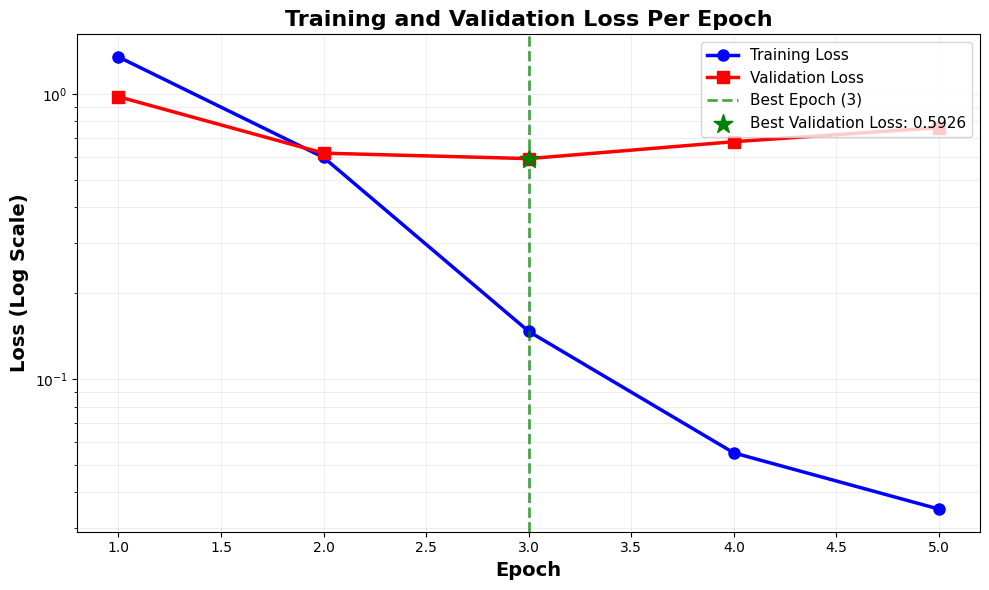

In [49]:
# Plotting code adapted from Claude AI.

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
epochs_range = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 6))

plt.semilogy(epochs_range, train_loss, 'b-o', label='Training Loss', linewidth=2.5, markersize=8)
plt.semilogy(epochs_range, val_loss, 'r-s', label='Validation Loss', linewidth=2.5, markersize=8)

best_epoch = np.argmin(val_loss) + 1
plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2,
            label=f'Best Epoch ({best_epoch})', alpha=0.7)
plt.scatter([best_epoch], [val_loss[best_epoch-1]], color='green', s=200,
            marker='*', zorder=5, label=f'Best Validation Loss: {val_loss[best_epoch-1]:.4f}')

plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss Per Epoch',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

- Model 1 creates a wide and deep network with 3 deep layers and roughly 27.8 million trainable parameters. 18 features were used in the input layer,

# Model 2

In [51]:
# Creates the second wide and deep network model with more layers

dict_inputs2 = feature_space.get_inputs()
encoded_features2 = feature_space.get_encoded_features()
crossed_outputs2 = []

for col in feature_space.crossers.keys():
    x = setup_embedding_from_encoding_crossing(encoded_features2, feature_space, col)
    crossed_outputs2.append(x)

wide_branch2 = Concatenate(name='wide_concat_2')(crossed_outputs2)

all_deep_branch_outputs2 = []

for col in numeric_headers:
    x = encoded_features2[col]
    # Casting line below adapted from Claude AI.
    x = keras.ops.cast(x, float)
    all_deep_branch_outputs2.append(x)

for col in categorical_headers:
    x = setup_embedding_from_encoding_categorical(encoded_features2,feature_space, col)
    all_deep_branch_outputs2.append(x)

#kernel_regularizer adapted from Claude AI
deep_branch2 = Concatenate(name='embed_concat_2')(all_deep_branch_outputs2)
deep_branch2 = Dense(units=50,activation='relu', kernel_regularizer=l2(0.001), name='deep1_2')(deep_branch2)
deep_branch2 = Dropout(0.7)(deep_branch2)
deep_branch2 = Dense(units=30,activation='relu', kernel_regularizer=l2(0.001), name='deep2_2')(deep_branch2)
deep_branch2 = Dropout(0.6)(deep_branch2)
deep_branch2 = Dense(units=25,activation='relu', kernel_regularizer=l2(0.001), name='deep3_2')(deep_branch2)
deep_branch2 = Dropout(0.5)(deep_branch2)
deep_branch2 = Dense(units=15,activation='relu', kernel_regularizer=l2(0.001), name='deep4_2')(deep_branch2)
deep_branch2 = Dropout(0.4)(deep_branch2)
deep_branch2 = Dense(units=10,activation='relu', kernel_regularizer=l2(0.001), name='deep5_2')(deep_branch2)
deep_branch2 = Dropout(0.3)(deep_branch2)

final_branch2 = Concatenate(name='concat_deep_wide_2')([deep_branch2, wide_branch2])
#softmax adapted from Claude AI
final_branch2 = Dense(units=4,activation='softmax',
                     name='combined_2')(final_branch2)

training_model2 = keras.Model(inputs=encoded_features2, outputs=final_branch2)
training_model2.compile(
    # categorical_crossentropy adapted from Claude AI.
    optimizer="adam", loss='categorical_crossentropy', metrics=['precision', 'recall']
)

training_model2.summary()
inference_model2 = keras.Model(inputs=dict_inputs2, outputs=final_branch2)
inference_model2.compile(loss='categorical_crossentropy', metrics=['precision', 'recall'])


# class weight calculation, early stopping, and learning rate reduction code adapted from Claude AI
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2, 3]),
    y=df_clean['order_grouped']
)
class_weight_dict = {i: class_weights[i] for i in range(4)}

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)


history2 = training_model2.fit(
    preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_val,
    class_weight=class_weight_dict, callbacks=[early_stop, reduce_lr],
    verbose=2
)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_646CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_647CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_648CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_649CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_650CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_651CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_652CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_653CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_654CL… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ customer_embed      │ (None, 1, 64)     │  1,702,272 │ keras_tensor_646… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ itemID_embed        │ (None, 1, 64)     │    513,472 │ keras_tensor_647… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_embed         │ (None, 1, 64)     │    491,584 │ keras_tensor_648… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_embed        │ (None, 1, 60)     │    222,360 │ keras_tensor_649… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ publisher_embed     │ (None, 1, 30)     │     27,300 │ keras_tensor_650… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_topic_embed    │ (None, 1, 21)     │      9,345 │ keras_tensor_651… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtopics_embed     │ (None, 1, 62)     │    241,862 │ keras_tensor_652… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_68 (Cast)      │ (None, 1)         │          0 │ keras_tensor_653

 Total params: 27,783,310 (105.98 MB)

 Trainable params: 27,783,310 (105.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
456/456 - 16s - 36ms/step - loss: 1.3839 - precision: 0.8438 - recall: 0.0914 - val_loss: 1.1213 - val_precision: 0.8587 - val_recall: 0.2007 - learning_rate: 1.0000e-03
Epoch 2/10
456/456 - 5s - 11ms/step - loss: 0.6444 - precision: 0.9118 - recall: 0.6742 - val_loss: 0.9134 - val_precision: 0.6843 - val_recall: 0.5005 - learning_rate: 1.0000e-03
Epoch 3/10
456/456 - 4s - 9ms/step - loss: 0.1604 - precision: 0.9875 - recall: 0.9700 - val_loss: 0.9187 - val_precision: 0.6469 - val_recall: 0.5822 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
456/456 - 4s - 9ms/step - loss: 0.0515 - precision: 0.9990 - recall: 0.9985 - val_loss: 0.9771 - val_precision: 0.6389 - val_recall: 0.5921 - learning_rate: 1.0000e-03
Epoch 5/10
456/456 - 5s - 10ms/step - loss: 0.0387 - precision: 0.9996 - recall: 0.9996 - val_loss: 1.0011 - val_precision: 0.6369 - val_recall: 0.5954 - learning_rate: 5.0000e-04
Epoch 5: early stopping


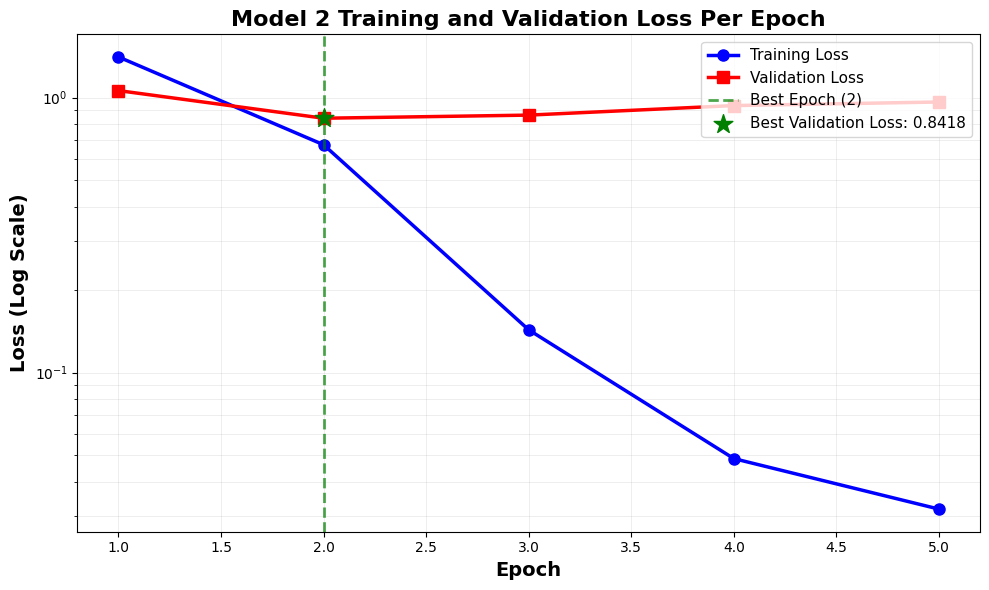

In [ ]:
# Plotting code adapted from Claude AI.

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
train_precision2 = history2.history['precision']
val_precision2 = history2.history['val_precision']
train_recall2 = history2.history['recall']
val_recall2 = history2.history['val_recall']
epochs_range2 = range(1, len(train_loss2) + 1)
plt.figure(figsize=(10, 6))

plt.semilogy(epochs_range2, train_loss2, 'b-o', label='Training Loss', linewidth=2.5, markersize=8)
plt.semilogy(epochs_range2, val_loss2, 'r-s', label='Validation Loss', linewidth=2.5, markersize=8)

best_epoch2 = np.argmin(val_loss2) + 1
plt.axvline(x=best_epoch2, color='green', linestyle='--', linewidth=2,
            label=f'Best Epoch ({best_epoch2})', alpha=0.7)
plt.scatter([best_epoch2], [val_loss2[best_epoch2-1]], color='green', s=200,
            marker='*', zorder=5, label=f'Best Validation Loss: {val_loss2[best_epoch2-1]:.4f}')

plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.title('Model 2 Training and Validation Loss Per Epoch',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Model 3

# Standard Multi-Layer Perceptron

In [76]:
# Multi-layer perceptron code adapted from Claude AI

from sklearn.preprocessing import LabelEncoder

all_features = numeric_headers + categorical_headers
X_train = train_df[all_features].copy()
X_val = val_df[all_features].copy()

for col in categorical_headers:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], val_df[col]]).astype(str)
    le.fit(all_values)

    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))

X_train = X_train.values
X_val = X_val.values
y_train = tf.keras.utils.to_categorical(train_df['order_grouped'], num_classes=4)
y_val = tf.keras.utils.to_categorical(val_df['order_grouped'], num_classes=4)

inputs = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)

mlp = Model(inputs=inputs, outputs=outputs)
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precision', 'recall'])

history_mlp = mlp.fit(X_train, y_train, epochs=20, batch_size=32,
                      validation_data=(X_val, y_val), verbose=2)
mlp.summary()

Epoch 1/20
913/913 - 12s - 13ms/step - loss: 79.5689 - precision: 0.5313 - recall: 0.5167 - val_loss: 1.2584 - val_precision: 0.6577 - val_recall: 0.6577
Epoch 2/20
913/913 - 3s - 3ms/step - loss: 2.4011 - precision: 0.6239 - recall: 0.5348 - val_loss: 0.7200 - val_precision: 0.6577 - val_recall: 0.6577
Epoch 3/20
913/913 - 3s - 3ms/step - loss: 1.1628 - precision: 0.6431 - recall: 0.6250 - val_loss: 0.6960 - val_precision: 0.6577 - val_recall: 0.6577
Epoch 4/20
913/913 - 3s - 3ms/step - loss: 0.8958 - precision: 0.6494 - recall: 0.6488 - val_loss: 0.7076 - val_precision: 0.6577 - val_recall: 0.6577
Epoch 5/20
913/913 - 4s - 4ms/step - loss: 0.8312 - precision: 0.6545 - recall: 0.6542 - val_loss: 0.6790 - val_precision: 0.6577 - val_recall: 0.6577
Epoch 6/20
913/913 - 3s - 3ms/step - loss: 0.7422 - precision: 0.6558 - recall: 0.6558 - val_loss: 0.6843 - val_precision: 0.6577 - val_recall: 0.6577
Epoch 7/20
913/913 - 3s - 3ms/step - loss: 0.7318 - precision: 0.6565 - recall: 0.6563 - va

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,638 (143.12 KB)

 Trainable params: 12,212 (47.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,426 (95.42 KB)